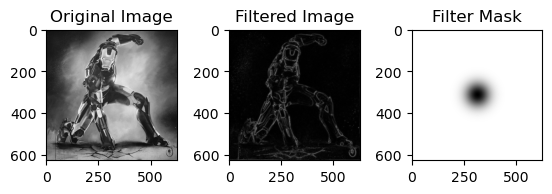

In [16]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import math

class FrequencyFilter:
    def __init__(self, loc, output_dir, method, filter_type, cutoff = None, cutoff_low=None, cutoff_high=None, order = None):
        # Read the input image
        self.image = cv2.imread(loc, cv2.IMREAD_GRAYSCALE)

        # Performing FFT on the original image
        self.rows, self.cols = self.image.shape
        F = np.fft.fft2(self.image)
        Fshift = np.fft.fftshift(F)

        # Apply the selected filter based on filter_type
        if method == 'ideal':
            if filter_type == 'lowpass':
                H = self.ideal_lowpass(cutoff)
            elif filter_type == 'highpass':
                H = self.ideal_highpass(cutoff)
            elif filter_type == 'bandpass':
                H = self.ideal_bandpass(cutoff_low, cutoff_high)
            elif filter_type == 'bandreject':
                H = self.ideal_bandreject(cutoff_low, cutoff_high)
            else:
                raise ValueError("Invalid filter_type. Use 'lowpass', 'highpass', 'bandpass', or 'bandreject'.")
        elif method == 'butterworth':
            if filter_type == 'lowpass':
                H = self.butterworth_lowpass(cutoff,order)
            elif filter_type == 'highpass':
                H = self.butterworth_highpass(cutoff, order)
            elif filter_type == 'bandpass':
                H = self.butterworth_bandpass(cutoff_low, cutoff_high, order)
            elif filter_type == 'bandreject':
                H = self.butterworth_bandreject(cutoff_low, cutoff_high, order)
            else:
                raise ValueError("Invalid filter_type. Use 'lowpass', 'highpass', 'bandpass', or 'bandreject'.")
        elif method == 'gaussian':
            if filter_type == 'lowpass':
                H = self.gaussian_lowpass(cutoff)
            elif filter_type == 'highpass':
                H = self.gaussian_highpass(cutoff)
            elif filter_type == 'bandpass':
                H = self.gaussian_bandpass(cutoff_low, cutoff_high)
            elif filter_type == 'bandreject':
                H = self.gaussian_bandreject(cutoff_low, cutoff_high)
            else:
                raise ValueError("Invalid filter_type. Use 'lowpass', 'highpass', 'bandpass', or 'bandreject'.")
        else:
            raise ValueError("Invalid method. Use 'ideal', 'butterworth', or 'gaussian'.")
                

        # Applying the filter in the frequency domain
        Gshift = Fshift * H
        G = np.fft.ifftshift(Gshift)
        self.filtered_image = np.abs(np.fft.ifft2(G))

        # Saving the filtered image
        output_path = os.path.join(output_dir, f'{filter_type.capitalize()}_Filtered_Image.png')
        cv2.imwrite(output_path, self.filtered_image)

        # Displaying the original and filtered images side by side
        plt.subplot(131), plt.imshow(self.image, cmap='gray'), plt.title('Original Image')
        plt.subplot(132), plt.imshow(self.filtered_image, cmap='gray'), plt.title('Filtered Image')
        plt.subplot(133), plt.imshow(H, cmap='gray'), plt.title('Filter Mask')
        plt.subplots_adjust(wspace=0.4)
        plt.show()

    def ideal_lowpass(self, cutoff):
        center_row, center_col = self.rows // 2, self.cols // 2
        # Create a mask with a circular region set to 1 and the rest set to 0
        H = np.zeros((self.rows, self.cols), np.uint8)  
        cv2.circle(H, (center_col, center_row), cutoff, (1, 1), -1)
        return H

    def ideal_highpass(self, cutoff):
        center_row, center_col = self.rows // 2, self.cols // 2
        # Creating a mask with a circular region set to 1 and the rest set to 0
        H = np.ones((self.rows, self.cols), np.uint8)  
        cv2.circle(H, (center_col, center_row), cutoff, (0, 0), -1)
        return H

    def ideal_bandpass(self, cutoff_low, cutoff_high):
        center_row, center_col = self.rows // 2, self.cols // 2
        # Create a mask with a circular region set to 1 and the rest set to 0
        H1 = np.ones((self.rows, self.cols), np.uint8) 
        cv2.circle(H1, (center_col, center_row), cutoff_low, (0, 0), -1)
        H2 = np.ones((self.rows, self.cols), np.uint8)  
        cv2.circle(H2, (center_col, center_row), cutoff_high, (0, 0), -1)
        H = H2 - H1
        return H
    
    def ideal_bandreject(self, cutoff_low, cutoff_high):
        center_row, center_col = self.rows // 2, self.cols // 2
        # Create a mask with a circular region set to 1 and the rest set to 0
        H1 = np.zeros((self.rows, self.cols), np.uint8)  
        cv2.circle(H1, (center_col, center_row), cutoff_low, (1, 1), -1)
        H2 = np.ones((self.rows, self.cols), np.uint8)  
        cv2.circle(H2, (center_col, center_row), cutoff_high, (0, 0), -1)
        H = H2 + H1
        return H
    
    def butterworth_lowpass(self, cutoff, order):
        #creating a butterworth filter
        H = np.zeros((self.rows,self.cols), dtype = np.float32)  #creating a 2D array same as image size
        for u in range(self.rows):
            for v in range(self.cols):
                D = np.sqrt((u-self.rows/2)**2 + (v-self.cols/2)**2)
                H[u,v] = 1 / (1+(D/cutoff)**(order))
        return H
    
    def butterworth_highpass(self, cutoff, order):
        #creating a butterworth filter
        H = np.zeros((self.rows,self.cols), dtype = np.float32)  #creating a 2D array same as image size
        for u in range(self.rows):
            for v in range(self.cols):
                D = np.sqrt((u - self.rows / 2) ** 2 + (v - self.cols / 2) ** 2)
                # Check for zero division
                if D != 0:
                    H[u, v] = 1 / (1 + (cutoff / D) ** (2 * order))
                else:
                    H[u, v] = 0
        return H

    def butterworth_bandpass(self, cutoff_low, cutoff_high, order):
        #creating a butterworth filter
        H = np.zeros((self.rows,self.cols), dtype = np.float32)  #creating a 2D array same as image size
        # Bandpass filter specifications
        W = cutoff_high-cutoff_low #width of the circle
        for u in range(self.rows):
            for v in range(self.cols):
                D = np.sqrt((u - self.rows / 2) ** 2 + (v - self.cols / 2) ** 2)
                H[u, v] = 1- (1 / (1 + (((D*W) / ((D**2) - (cutoff_low**2)))**(2 * order))))
        return H
    
    def butterworth_bandreject(self, cutoff_low, cutoff_high, order):
        #creating a butterworth filter
        H = np.zeros((self.rows,self.cols), dtype = np.float32)  #creating a 2D array same as image size
        # Bandpass filter specifications
        W = cutoff_high-cutoff_low #width of the circle
        for u in range(self.rows):
            for v in range(self.cols):
                D = np.sqrt((u - self.rows / 2) ** 2 + (v - self.cols / 2) ** 2)
                H[u, v] = (1 / (1 + (((D*W) / ((D**2) - (cutoff_low**2)))**(2 * order))))
        return H
    
    def gaussian_lowpass(self, cutoff):
        #creating a butterworth filter
        H = np.zeros((self.rows,self.cols), dtype = np.float32)  #creating a 2D array same as image size
        for u in range(self.rows):
            for v in range(self.cols):
                D = np.sqrt((u-self.rows/2)**2 + (v-self.cols/2)**2)
                H[u,v] =np.exp(-D**2/(2*(cutoff**2)))
        return H
    
    def gaussian_highpass(self, cutoff):
        #creating a butterworth filter
        H = np.zeros((self.rows,self.cols), dtype = np.float32)  #creating a 2D array same as image size
        for u in range(self.rows):
            for v in range(self.cols):
                D = np.sqrt((u-self.rows/2)**2 + (v-self.cols/2)**2)
                H[u,v] =np.exp(-D**2/(2*(cutoff**2)))
        H = 1 - H
        return H

    def gaussian_bandpass(self, cutoff_low, cutoff_high):
        #creating a butterworth filter
        H = np.zeros((self.rows,self.cols), dtype = np.float32)  #creating a 2D array same as image size
        # Bandpass filter specifications
        W = cutoff_high-cutoff_low #width of the circle
        for u in range(self.rows):
            for v in range(self.cols):
                D = np.sqrt((u - self.rows / 2) ** 2 + (v - self.cols / 2) ** 2)
                H[u, v] = math.exp(-((D**2 - cutoff_low**2)/(D*W))**(2))
        return H
    
    def gaussian_bandreject(self, cutoff_low, cutoff_high):
        #creating a butterworth filter
        H = np.zeros((self.rows,self.cols), dtype = np.float32)  #creating a 2D array same as image size
        # Bandpass filter specifications
        W = cutoff_high-cutoff_low #width of the circle
        for u in range(self.rows):
            for v in range(self.cols):
                D = np.sqrt((u - self.rows / 2) ** 2 + (v - self.cols / 2) ** 2)
                H[u, v] = 1 - math.exp(-((D**2 - cutoff_low**2)/(D*W))**(2))
        return H


# Example usage:
loc = r'im2.jpg'
output_dir =r'C:\Users\Tanjib Ahmed\Desktop\images'

# Create an instance of the class with the desired filter type
FrequencyFilter(loc, output_dir, method = 'gaussian', filter_type='highpass', cutoff = 40)